<a href="https://colab.research.google.com/github/puneat/Algorithmic_Portfolio/blob/master/Portfolio_Investment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [2]:
!pip3 install ta

  Created wheel for ta: filename=ta-0.5.25-cp36-none-any.whl size=24880 sha256=f81b291d80a886542492f6b313a32b5056199d63d889b670a7da81913a7b54a4
  Stored in directory: /root/.cache/pip/wheels/2e/93/b7/cf649194508e53cee4145ffb949e9f26877a5a8dd12db9ed5b
Successfully built ta


In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
import pandas as pd
from ta import add_all_ta_features
from ta.utils import dropna
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import statsmodels as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [27]:
def read_price_data(idx):
  open = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/open_price.csv')
  close = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/close_price.csv')
  high = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/high_price.csv')
  low = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/low_price.csv')
  bb_live = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/bb_live.csv')
  volume = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/volume.csv')

  open=open.iloc[:,[0,idx]]
  close=close.iloc[:,[0,idx]]
  high=high.iloc[:,[0,idx]]
  low=low.iloc[:,[0,idx]]
  bb_live=bb_live.iloc[:,[0,idx]]
  volume=volume.iloc[:,[0,idx]]

  open=open.set_index('date')
  close=close.set_index('date')
  high=high.set_index('date')
  low=low.set_index('date')
  bb_live=bb_live.set_index('date')
  volume=volume.set_index('date')

  result = pd.concat([open,high,low,close,volume,bb_live], axis=1).reindex(bb_live.index)
  result.columns = ['open','high','low','close','volume','bb_live'] 
  return result

def data_load(idx):
  prices = read_price_data(idx)
  tech_ind = add_all_ta_features(prices, open="open", high="high", low="low", close="close", volume="volume")
  secondary_index_data = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/secondary_data.csv')
  secondary_index_data=secondary_index_data.set_index('date')

  ind=pd.concat([tech_ind, secondary_index_data], axis=1).reindex(tech_ind.index)
  #ind=tech_ind
  ind=ind.dropna(axis=1,how='all',thresh=2000)
  ind=ind.dropna(axis=0)

  #equity=sp500_hist_data.iloc[:,[0,idx]]
  #missing_values = set(ind.iloc[:, 0]).symmetric_difference(set(equity.iloc[:, 0]))
  #missing_values=list(missing_values)
  #print(len(missing_values))
  #ind = ind[~ind['date'].isin(missing_values)]
  #equity = equity[~equity['date'].isin(missing_values)]
  X=ind.iloc[:,6:]
  y=ind.iloc[:,3]
  return X, y

def input_data(trainx,trainy,index):
  trainx=trainx.to_numpy()
  trainy=trainy.to_numpy()
  trainX, trainY = trainx[:index,:], trainy[:index]
  validX, validY = trainx[index:,:], trainy[index:]
  scaler = StandardScaler()
  trainX=scaler.fit_transform(trainX)
  validX=scaler.transform(validX)
  return trainX, trainY, validX, validY

def remove_features(trainX,trainY):
  corr_matrix=[]
  for idx in range(0,trainX.shape[1]): 
    corr=np.corrcoef(trainX.iloc[:,idx].to_numpy(),trainY.to_numpy())
    corr_matrix.append(corr[0,1]*100)
    idx_list=[]
  for i,val in enumerate(corr_matrix):
    if (val<=5 and val>=-5):
      idx_list.append(i)
    #elif (val>=98):
    #  idx_list.append(i)
  trainX=trainX.drop(columns=trainX.columns[idx_list])
  return trainX,trainY, corr_matrix

def sp500_returns():
  close = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/close_price.csv')
  close = close.set_index('date')
  #close = close.fillna(0)
  close = close.pct_change()[1:]
  #close = close.sort_values(by=list(close.columns),axis=0)
  return close    

An Equal weighted portfolio with 10 stocks, rebalanced each day with that days 10 highest returns generating stocks.

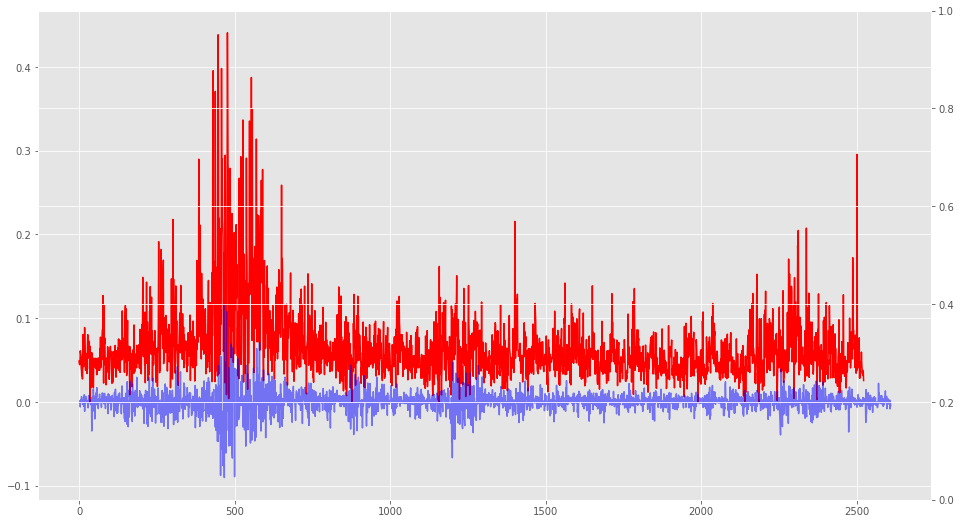

In [80]:
secondary_index_data = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/secondary_data.csv')
secondary_index_data = secondary_index_data['SPX Index']
secondary_index_data=secondary_index_data.pct_change()
return_matrix = sp500_returns()

weights=[1/10]*10
cum_return=[]
for day in range(0, return_matrix.shape[0]):
  day_return=[]
  for comp in range(0, return_matrix.shape[1]):
    day_return.append(return_matrix.iloc[day,comp])
  day_return = [x for x in day_return if (str(x) != 'nan' and x<1)]
  day_return.sort(reverse=True)
  day_return=day_return[:10]
  res_list = [weights[i] * day_return[i] for i in range(len(day_return))]
  cum_return.append(sum(res_list))

matplotlib.style.use('ggplot')
fig, ax1 = plt.subplots(figsize=(16, 9))
ax2 = ax1.twinx()
ax1.plot(cum_return,color='red')
ax1.plot(secondary_index_data,color='blue',alpha=0.5)  

In [ ]:
sp500_hist_data = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/close_price.csv')
sp500_companies = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/company_data.csv')
secondary_index_data = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/secondary_data.csv')

### **LightGBM**

In [ ]:
#model parameters
param = {'num_leaves':300, 'objective':'mse','max_depth':20,'learning_rate':0.1,'max_bin':200, 'seed':15, 'verbose': -1}
param['metric'] = ['mse']

#model variables initialisation
model=None
evals_result = {} #store batch results
cum_results = {'training':[], 'valid_1':[]} #store all results

In [ ]:
#training loop
trainValidSplit = 0.75
roundPerBatch = 5000
#trainx=ind.to_numpy()
#trainy=equity.to_numpy()

In [ ]:
#training loop
#build training and validation gbm dataset objects
for i in range(43,44):
  ind, equity = data_load(i)
  newX,newY=remove_features(ind,equity)
  trainX, trainY, validX, validY = input_data(newX,newY)
  train_data = lgb.Dataset(trainX, label=trainY)
  validation_data = lgb.Dataset(validX,label=validY)
  #train model
  model = lgb.train(param, train_data, roundPerBatch,
                      valid_sets=[train_data, validation_data],
                      evals_result=evals_result,
                      verbose_eval=1,init_model=model)
  cum_results['training'] += (evals_result['training']['l2'])
  cum_results['valid_1'] += (evals_result['valid_1']['l2'])
  #if i != int((sp500_hist_data.shape[1]/2)-1):
   # del ind,equity,trainX, trainY, validX, validY,train_data,validation_data

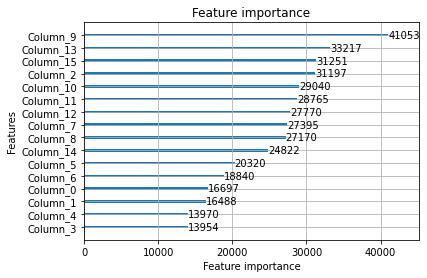

In [ ]:
lgb.plot_importance(model, max_num_features=16);

### **Quantile Regression**

In [ ]:
ind, equity = data_load(43)
ind,equity,corr=remove_features(ind,equity)
#ind.info()
trainX, trainY, validX, validY = input_data(ind,equity,500)
print(trainX.shape, trainY.shape, validX.shape, validY.shape)
mod = sm.regression.quantile_regression.QuantReg(trainY, trainX)
model = mod.fit(q=.5,kernel='gau')
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ta/trend.py:608: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:612: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


(500, 23) (500,) (1375, 23) (1375,)
                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               -5.755
Model:                       QuantReg   Bandwidth:                       1.784
Method:                 Least Squares   Sparsity:                   6.580e+291
Date:                Wed, 16 Sep 2020   No. Observations:                  500
Time:                        15:47:35   Df Residuals:                      477
                                        Df Model:                           23
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1244        nan        nan        nan         nan         nan
x2             6.3341        nan        nan        nan         nan         nan
x3             0.5473        nan        nan        nan         nan         nan
x4             0

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: overflow encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


### **Support Vector Quantile Regression**

In [ ]:
!pip3 install liquidSVM

     |████████████████████████████████| 563kB 4.9MB/s 
  Created wheel for liquidSVM: filename=liquidSVM-1.0.1-cp36-cp36m-linux_x86_64.whl size=2578630 sha256=692a7a1a56bf1a14fc82451cd6020a20de808647eeee3d9b5f78701ff92f6644
  Stored in directory: /root/.cache/pip/wheels/85/3f/fc/daaad6cff352e71e2eab30b54adaec90108fc2908324c0511a
Successfully built liquidSVM


In [ ]:
from liquidSVM import LiquidData,qtSVM

In [ ]:
reg = LiquidData('reg-1d')
print(reg.train)

{'data': array([[0.28986675],
       [0.19561529],
       [0.23956186],
       ...,
       [0.90154848],
       [0.95844949],
       [1.06665809]]), 'target': array([0.42561854, 0.36602415, 0.33559088, ..., 0.44949226, 0.38824736,
       0.49917251]), 'DESCR': 'reg-1d (train)'}


In [ ]:
quantiles_list = [ 0.05, 0.1, 0.5, 0.9, 0.95 ]

ind, equity = data_load(43)
ind,equity,corr=remove_features(ind,equity)
trainX, trainY, validX, validY = input_data(ind,equity,500)
print(trainX.shape, trainY.shape, validX.shape, validY.shape)
print(data.shape)
model = qtSVM(reg.train, weights=quantiles_list,)

result, err = model.test(reg.test)
err[:,0]

/usr/local/lib/python3.6/dist-packages/ta/trend.py:608: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:612: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


(500, 70) (500,) (1375, 70) (1375,)


ValueError: ignored

### **Support Vector Regression**

In [ ]:
tuned_parameters = [{'kernel': ['poly'], 'gamma': ['auto'],
                     'C': [1, 10,20,30,40,50,60,70,80,90, 100, 1000], 'degree':[1,2,3,4],'epsilon':[0.01,0.05,0.1,0.2,0.3,0.4,0.5],
                    'coef0':[1,2,3,4,5,6,7,8,9,10]}]
#svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)

score=['neg_mean_squared_error']
ind, equity = data_load(300)
ind,equity,corr=remove_features(ind,equity)
trainX, trainY, validX, validY = input_data(ind,equity,700)
print(trainX.shape, trainY.shape, validX.shape, validY.shape)

model = GridSearchCV(
        SVR(), tuned_parameters
    )
model.fit(trainX, trainY)
#model = svr_poly.fit(trainX, trainY)
print(model.score(validX,validY))

/usr/local/lib/python3.6/dist-packages/ta/trend.py:608: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:612: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


(700, 70) (700,) (1175, 70) (1175,)
0.9999806815253335


In [ ]:
model.best_params_

In [19]:
svr_poly = SVR(kernel='poly', C=250, gamma='auto', degree=2, epsilon=.1, coef0=10)
svr_linear = SVR(kernel='linear',C=100,epsilon=0.1)
ind, equity = data_load(300)
days=100
ind,equity,corr=remove_features(ind,equity)
trainX, trainY, validX, validY = input_data(ind,equity,days)
print(trainX.shape, validX.shape, trainY.shape, validY.shape)
model_p = svr_poly.fit(trainX, trainY,)
model_l = svr_linear.fit(trainX, trainY,)
print(mean_absolute_error(validY, model_p.predict(validX)), model_p.score(validX,validY))
#print(model_p.score(validX,validY),model_l.score(validX,validY))

(100, 70) (1775, 70) (100,) (1775,)
0.954597166311691 0.9555653393047742


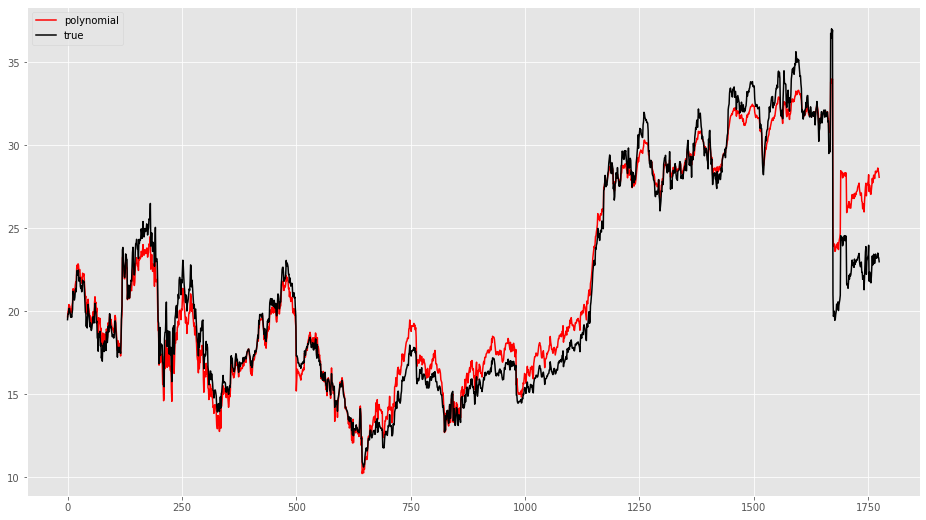

In [20]:
#ypred_stack = stack.predict(validX)
ypred_poly = model_p.predict(validX)
matplotlib.style.use('ggplot')
fig, ax1 = plt.subplots(figsize=(16, 9))
#ax2 = ax1.twinx()
# ax1.plot(ypred_stack,color='green')
ax1.plot(ypred_poly,color='red')
ax1.plot(validY,color='black')
ax1.legend(['polynomial','true'])